# MIS 583 Assignment #7 Text Sentiment Classification

## Overview

**Sentiment Classification** is an automated process of identifying opinions in text and labeling them as positive, negative, or neutral, based on the emotions customers express within them.

In this assignment, you need to train a recurrent neural network (RNN)or fine-tune a pre-trained language model (e.g., BERT) to predict thesentiment of given tweet.

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

I use `python 3.8.11`, `torch==1.8.2` and `torchvision==0.9.2`.  
I use `transformers==4.8.2`.

In [1]:
import sys
import torch
import torchvision
import transformers
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)
print('transformers', transformers.__version__)

python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
torch 1.10.1+cu113
torchvision 0.11.2+cu113
transformers 4.15.0


## Loading Model and Data

First, we are going to talk about the model.  
HuggingFace team have created an amazing framework called "transformers" for NLP tasks.  
It havs many State-of-the-art Machine Learning for Pytorch, TensorFlow, and JAX.  

To start with this package, follow [this link to installation and basic tutorial](https://pytorch.org/hub/huggingface_pytorch-transformers/).

In [2]:
from torch import nn
from transformers import DistilBertTokenizer
from transformers import BertForSequenceClassification
#########################################################################
#            Loading tokenizer and model from transformer               #
#########################################################################
# from transformers import xxx

bert_type = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(bert_type)
# create a Bert-extended task (classification)
model = BertForSequenceClassification.from_pretrained(bert_type)

# finetune from the output from bert to your task
model.classifier = nn.Linear(768, 3, bias=True)
#########################################################################
#                          End of your code                             #
#########################################################################

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.2.attention.out_lin.weight', 'distilbert.transformer.layer.5.ffn.lin2.bias', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.1.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.v_lin.weight', 'distilbert.embeddings.word_embeddings.weight', 'distilbert.transformer.layer.4.ffn.lin2.weight', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'distilbert.transformer.layer.2.attention.q_lin.bias', 'distilbert.transformer.layer.1.output_layer_norm.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transform





## How to Get Data

Please open the file `twitter_sentiment.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/14SdYQ6FSowQnWVCd4dP12jQMjX9-YJIh/view?usp=sharing)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

---

請先到共用雲端硬碟將檔案 `twitter_sentiment.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/14SdYQ6FSowQnWVCd4dP12jQMjX9-YJIh/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

1. Executing the below code which will provide you with an authentication link
2. Open the link
3. Choose the Google account whose Drive you want to mount
4. Allow Google Drive Stream access to your Google Account
5. Copy the code displayed, paste it in the text box as shown below, and press Enter
![](https://i1.wp.com/neptune.ai/wp-content/uploads/colab-code-copy.png?resize=512%2C102&ssl=1)

Finish!

---

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

## Unzip Data

Unzip `twitter_sentiment.zip`, there are 3 csv files.

- `train.csv`, `test.csv` and `val.csv`

There are **10248** datas in training set.  
There are **1461** datas in validation set.  
There are **2928** datas in testing set.  

---

解壓縮 `twitter_sentiment.zip` 後可以發現裡面有兩個資料夾和三個csv檔。

- `train.csv`, `test.csv` and `val.csv`

Training set 有 **10248** 筆資料.  
Validation set 有 **1461** 筆資料.  
Testing set 有 **2928** 筆資料.  

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [3]:
# Utility function to extract text and label from csv file
def get_texts(f_name='hw3/twitter_sentiment', mode='train'):
    text_list = []
    label_list = []
    
    f_path = os.path.join(f_name, '{}.csv'.format(mode))
    with open(f_path,encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for line in reader:
            text_list.append(line['text'])
            if mode != 'test':
                label_list.append(int(line['sentiment_label']))

    return text_list, label_list

In [4]:
import os
import csv
import torch
from torch.utils.data import Dataset, DataLoader
class TwitterDataset(Dataset):
    def __init__(self, f_name='hw3/twitter_sentiment', mode='train'):
        self.mode = mode
        
        text_list, label_list = get_texts(f_name, mode)
        print('mode', mode, 'has', len(text_list), 'datas')
        text_list = tokenizer(text_list,
                             truncation=True, padding=True,
                             return_tensors='pt')

        self.text_list = text_list['input_ids']
        self.mask_list = text_list['attention_mask']

        self.label_list = label_list
    
    def __getitem__(self, idx):
        text = self.text_list[idx]
        mask = self.mask_list[idx]
        if self.mode == 'test':
            return text, mask
        label = torch.tensor(self.label_list[idx])
        return text, mask, label

    def __len__(self):
        return len(self.text_list)

In [5]:
dataset_train = TwitterDataset(mode='train')
dataset_val = TwitterDataset(mode='val')
dataset_test = TwitterDataset(mode='test')

batch_size = 32
train_data = DataLoader(dataset_train, batch_size=batch_size,
                       shuffle=True)
val_data = DataLoader(dataset_val, batch_size=batch_size // 2,
                       shuffle=False)
test_data = DataLoader(dataset_test, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1464 datas
mode test has 2928 datas


In [6]:
t = tokenizer.convert_ids_to_tokens(dataset_train[0][0])
print('token', t)
print('token to s', tokenizer.convert_tokens_to_string(t))

token ['[CLS]', '@', 'united', 'sat', 'at', 'airport', 'for', '5', 'hr', '##s', 'still', 'sitting', 'at', 'gate', '.', '.', 'sigh', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
token to s [CLS] @ united sat at airport for 5 hrs still sitting at gate . . sigh [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [7]:
device = torch.device('cuda')

from torch import nn
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

## Utility Function

In [8]:
def accuracy(raw_preds, y):
    preds = raw_preds.argmax(dim=1)
    acc = (preds == y).sum()
    return acc

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_loss_list = []
val_loss_list = []

def train(model, data, optimizer, criterion):
    model.train()
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)
        
        #########################################################################
        #                          Testing process                              #
        #########################################################################
        # 1. clean the gradients of optimizer
        # 2. put correct variables into model
        # 3. get prediction
        # 4. Evalutate by criterion and accuracy
        optimizer.zero_grad()
        output = model(text,mask)
        loss = criterion(output[0],label)
        acc = accuracy(output[0],label)
        #########################################################################
        #                          End of your code                             #
        #########################################################################
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        train_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

def test(model, data, criterion, log_loss=False):
    model.eval()
    
    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        #########################################################################
        #                          Training process                             #
        #########################################################################
        # 1. put correct variables into model
        # 2. get prediction
        # 3. Evalutate by criterion and accuracy
        output = model(text,mask)
        loss = criterion(output[0],label)
        acc = accuracy(output[0],label)
        #########################################################################
        #                          End of your code                             #
        #########################################################################
        
        epoch_loss += loss.item()
        if log_loss:
            val_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

# class for monitoring train and test acc/loss
class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []
    
    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss_list.append(train_loss)
        self.train_acc_list.append(train_acc)
        self.val_loss_list.append(val_loss)
        self.val_acc_list.append(val_acc)
    
    def plot(self):
        x = range(len(self.train_loss_list))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train_acc', 'val_acc'])
        plt.show()

## Start Training

In [13]:
#########################################################################
#                          Hyper-parameters                             #
#########################################################################
max_epoch = 20
log_interval = 2
best_acc = 0
#########################################################################
#                          End of your code                             #
#########################################################################

m = Meter()

for epoch in range(1, max_epoch + 1):
    train_loss, train_acc = train(model, train_data, optimizer, criterion)
    val_loss, val_acc = test(model, val_data, criterion, log_loss=True)
    
    if epoch % log_interval == 0:
        print('Epoch {} train_loss: {} train_acc: {}'.format(
            epoch, train_loss, train_acc
        ))
        print('Epoch {} val_loss:  {} val_acc : {}'.format(
            epoch, val_loss, val_acc
        ))
    
    m.update(train_loss, train_acc, val_loss, val_acc)
    
    # model checkpoint
    torch.save(model.state_dict(), 'NAME_OF_THIS_EXPERIMENT.pt'.format(epoch))
    if val_acc > best_acc:
        best_model = model
        best_acc = val_acc
        print('-'*10, 'e', epoch, 'save best model', '-'*10)

100%|██████████| 92/92 [00:01<00:00, 48.17it/s]


---------- e 1 save best model ----------


100%|██████████| 92/92 [00:01<00:00, 48.09it/s]


Epoch 2 train_loss: 0.00535914862992287 train_acc: 0.9402810304449649
Epoch 2 val_loss:  0.048372429974957325 val_acc : 0.7903005464480874


100%|██████████| 92/92 [00:01<00:00, 48.01it/s]


---------- e 3 save best model ----------


100%|██████████| 92/92 [00:01<00:00, 48.05it/s]


Epoch 4 train_loss: 0.003574912293127445 train_acc: 0.962431693989071
Epoch 4 val_loss:  0.05430388017150426 val_acc : 0.8046448087431693


100%|██████████| 92/92 [00:01<00:00, 48.02it/s]


Epoch 6 train_loss: 0.0024049586356453202 train_acc: 0.9760928961748634
Epoch 6 val_loss:  0.056698282772186595 val_acc : 0.8066939890710383
---------- e 6 save best model ----------


100%|██████████| 92/92 [00:01<00:00, 48.02it/s]


Epoch 8 train_loss: 0.0023130617390238082 train_acc: 0.9770686963309914
Epoch 8 val_loss:  0.06117938193327192 val_acc : 0.7780054644808743


100%|██████████| 92/92 [00:01<00:00, 47.87it/s]


Epoch 10 train_loss: 0.001985639156489237 train_acc: 0.9815573770491803
Epoch 10 val_loss:  0.06365088992077816 val_acc : 0.7745901639344263


100%|██████████| 92/92 [00:01<00:00, 47.89it/s]


Epoch 12 train_loss: 0.0017121173590450758 train_acc: 0.9824355971896955
Epoch 12 val_loss:  0.06768508068326597 val_acc : 0.7848360655737705


100%|██████████| 92/92 [00:01<00:00, 47.85it/s]


Epoch 14 train_loss: 0.0014901425689731482 train_acc: 0.9863387978142076
Epoch 14 val_loss:  0.0588755694776519 val_acc : 0.7943989071038251


100%|██████████| 92/92 [00:01<00:00, 48.32it/s]


Epoch 16 train_loss: 0.0013147946246406194 train_acc: 0.987607338017174
Epoch 16 val_loss:  0.07405286030767516 val_acc : 0.7868852459016393


100%|██████████| 92/92 [00:01<00:00, 48.36it/s]


Epoch 18 train_loss: 0.0013447562312189024 train_acc: 0.9864363778298204
Epoch 18 val_loss:  0.05817345275462203 val_acc : 0.7943989071038251


100%|██████████| 92/92 [00:01<00:00, 48.27it/s]


Epoch 20 train_loss: 0.0008988682152061803 train_acc: 0.9919984387197502
Epoch 20 val_loss:  0.07362985148672219 val_acc : 0.7780054644808743


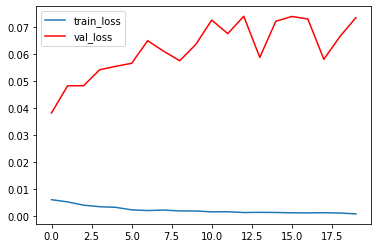

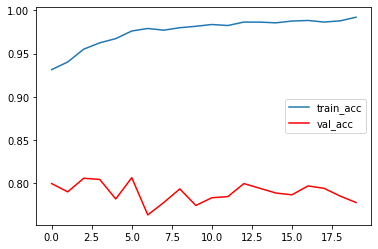

In [14]:
# plot them out
m.plot()

## Prediction

In [15]:
best_model.eval()

total_out = []
for text, mask in tqdm(test_data, total=len(test_data)):
    text = text.to(device)
    mask = mask.to(device)

    output = best_model(text, mask)
    pred = output.logits
    pred = torch.argmax(pred, dim=1)
    total_out.append(pred)

total_out = torch.cat(total_out).cpu().numpy().tolist()

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(total_out):
        f.write('{},{}\n'.format(i, pred))

100%|██████████| 183/183 [00:04<00:00, 45.44it/s]
